# Fewshot Model with 20% Ploymer data Fine tuned on Only Molecule model


##  GPU Avaiablity Chcek

In [1]:
import os
import subprocess
import torch

def get_filtered_free_gpus(allowed_gpus={0, 2, 3}):
    """Return (gpu_id, free_mem_MB) from allowed_gpus, sorted by free memory."""
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=index,memory.free', '--format=csv,noheader,nounits'],
            encoding='utf-8'
        )
        gpu_info = []
        for line in result.strip().split('\n'):
            gpu_id, mem_free = line.strip().split(',')
            gpu_id = int(gpu_id)
            mem_free = int(mem_free)
            if gpu_id in allowed_gpus:
                gpu_info.append((gpu_id, mem_free))
        return sorted(gpu_info, key=lambda x: x[1], reverse=True)
    except Exception as e:
        print("⚠️ Could not query GPU info:", e)
        return []

# Step 1: Get preferred GPU (among 0, 2, 3)
available_gpus = get_filtered_free_gpus()

if available_gpus:
    selected_system_gpu = available_gpus[0][0]
    os.environ["CUDA_VISIBLE_DEVICES"] = str(selected_system_gpu)
    print(f"🧠 Selected system GPU ID: {selected_system_gpu} with {available_gpus[0][1]} MB free memory.")
else:
    print("⚠️ No preferred GPUs available. Using CPU.")

# Step 2: PyTorch setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    visible_device_name = torch.cuda.get_device_name(current_device)
    visible_ids = os.environ["CUDA_VISIBLE_DEVICES"].split(",")
    real_system_gpu_id = visible_ids[current_device]

    print("✅ GPU is available!")
    print(f"🖥️ Visible PyTorch Device: cuda:{current_device}")
    print(f"🧭 Actual system GPU ID: {real_system_gpu_id}")
    print(f"📟 GPU Name: {visible_device_name}")
else:
    print("⚠️ GPU not available. Using CPU.")

print(f"Model will run on: {device}")



🧠 Selected system GPU ID: 2 with 40323 MB free memory.
✅ GPU is available!
🖥️ Visible PyTorch Device: cuda:0
🧭 Actual system GPU ID: 2
📟 GPU Name: NVIDIA A100-SXM4-40GB
Model will run on: cuda


In [2]:
import os
print("My PID:", os.getpid())


My PID: 3801719


## 1. # IMPORTS AND GLOBAL CONFIGURATIONS

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from tqdm.notebook import tqdm
import warnings
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("Libraries imported and random seed set.")

Libraries imported and random seed set.


In [4]:
# --- CONFIGURATION AND PATHS FOR FEW-SHOT ---
BASE_MODEL_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Fewshot_DNN_Model_2/models/base_model.pt"
PARAMS_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Fewshot_DNN_Model_2/optuna_results/best_params.json"
POLYMER_DATA_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Fewshot_DNN_Model_2/polymer_DNN_encoded_final_data.csv"

# Directory to save new results
RESULTS_DIR = "./results_fewshot"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Define class names for plotting and reports
class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']

print("Configuration for Few-Shot evaluation is set.")

Configuration for Few-Shot evaluation is set.


## 2. DEFINE YOUR DNN MODEL CLASS(ToxiciityDNN CLASS DEFINITION )

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ToxicityDNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation_names, activation_params_list):
        super(ToxicityDNN, self).__init__()
        self.n_layers = len(hidden_dims)
        self.dropout_rates = dropout_rates
        self.activation_names = activation_names # Store for potential later inspection if needed
        self.activation_params_list = activation_params_list # Store for potential later inspection if needed

        self.activation_modules = nn.ModuleList() # Use ModuleList for activations

        # Combine Linear and Dropout layers into a single ModuleList for simpler iteration
        self.linear_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        in_dim = input_dim

        for i in range(self.n_layers):
            out_dim = hidden_dims[i]
            self.linear_layers.append(nn.Linear(in_dim, out_dim)) # Append linear layer

            # Create activation module for the current layer
            activation_name = activation_names[i]
            # Safely get params for the current layer, default to empty dict if index out of bounds
            activation_params = activation_params_list[i] if i < len(activation_params_list) else {}

            if activation_name == 'ReLU':
                self.activation_modules.append(nn.ReLU())
            elif activation_name == 'PReLU':
                # num_parameters should match the input feature dimension if you want one param per feature
                # or just 1 if shared across all features. For simplicity, we'll keep 1 as in your original
                self.activation_modules.append(nn.PReLU(num_parameters=1, init=activation_params.get('init', 0.25)))
            elif activation_name == 'SiLU':
                self.activation_modules.append(nn.SiLU())
            elif activation_name == 'LeakyReLU':
                self.activation_modules.append(nn.LeakyReLU(negative_slope=activation_params.get('negative_slope', 0.01)))
            elif activation_name == 'ELU':
                self.activation_modules.append(nn.ELU(alpha=activation_params.get('alpha', 1.0)))
            elif activation_name == 'GELU':
                self.activation_modules.append(nn.GELU())
            else:
                raise ValueError(f"Unknown activation function: {activation_name}")

            self.dropout_layers.append(nn.Dropout(dropout_rates[i])) # Append dropout layer
            in_dim = out_dim

        # Output layer
        self.output_layer = nn.Linear(in_dim, 3) # Assuming 3 output classes

    # ONLY ONE FORWARD METHOD
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.linear_layers[i](x)      # Apply Linear layer
            x = self.activation_modules[i](x) # Apply specific activation for this layer
            x = self.dropout_layers[i](x)     # Apply Dropout layer

        x = self.output_layer(x)
        return x

    # Remove or modify get_activation_info if you need it to reflect per-layer info
    # For example, to get info for all layers:
    def get_all_activation_info(self):
        """
        Get information about activation functions used in all layers.
        """
        info = []
        for i in range(self.n_layers):
            info.append({
                'name': self.activation_names[i],
                'params': self.activation_params_list[i]
            })
        return info

## 3. DEFINE  DATASET CLASS (e.g., PolymerToxicityDataset)

In [6]:
class PolymerToxicityDataset(Dataset):
    def __init__(self, dataframe, fingerprint_col='fingerprints', property_cols=None, target_col='Hazard_Criteria_encoded'):
        """
        Initialize the dataset.
        
        Args:
            dataframe: Pandas DataFrame containing the data
            fingerprint_col: Column name for fingerprint vectors
            property_cols: List of property column names (one-hot encoded)
            target_col: Column name for the target variable
        """
        self.dataframe = dataframe
        self.fingerprint_col = fingerprint_col
        self.property_cols = property_cols if property_cols else []
        self.target_col = target_col
        
        # Convert string representation of lists to actual lists for fingerprints
        self.fingerprints = self.dataframe[fingerprint_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).tolist()
        
        # Get property features if available
        if self.property_cols:
            self.properties = self.dataframe[self.property_cols].values
        
        # Get targets
        self.targets = self.dataframe[target_col].values
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get fingerprint features
        fingerprint = torch.tensor(self.fingerprints[idx], dtype=torch.float32)
        
        # Combine with property features if available
        if self.property_cols:
            properties = torch.tensor(self.properties[idx], dtype=torch.float32)
            features = torch.cat([fingerprint, properties], dim=0)
        else:
            features = fingerprint
        
        # Get target
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        
        return features, target

## 3. DEFINE ALL UTILITY FUNCTIONS

(Place ALL your function definitions here, in this general order of dependency)

## 3.1  Utility function to compute class weights, traiing history and confusion matrix

In [7]:
# Function to compute class weights for imbalanced data
def compute_class_weights(targets):
    """
    Compute class weights inversely proportional to class frequencies.
    
    Args:
        targets: Target labels
        
    Returns:
        Tensor of class weights
    """
    class_counts = np.bincount(targets)
    total_samples = len(targets)
    
    # Compute weights inversely proportional to class frequencies
    weights = total_samples / (len(class_counts) * class_counts)
    
    # Normalize weights
    weights = weights / weights.sum()
    
    return torch.tensor(weights, dtype=torch.float32).to(device)

# Plot training history
def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss and accuracy.
    
    Args:
        history: Training history dictionary
        save_path: Path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, save_path=None):
    """
    Plot confusion matrix.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        save_path: Path to save the plot
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

### Base model with best parameters including activation function support

In [8]:
# Place this in your "4. DEFINE ALL UTILITY FUNCTIONS" section
# if you did not have it already.

def create_enhanced_model_with_best_params(best_params, input_dim):
    """
    Create enhanced model with best parameters including activation function support.
    This function correctly extracts per-layer activation names and parameters
    from the best_params dictionary generated by Optuna.
    """
    n_layers = best_params['n_layers']
    hidden_dims = [best_params[f'hidden_dim_{i}'] for i in range(n_layers)]
    dropout_rates = [best_params[f'dropout_{i}'] for i in range(n_layers)]

    # --- Section for extracting per-layer activations ---
    activation_names = []
    activation_params_list = []

    for i in range(n_layers):
        current_activation_name = best_params[f'activation_{i}']
        activation_names.append(current_activation_name)

        current_activation_params = {}
        # Check if the specific activation parameter exists for this layer
        if current_activation_name == 'PReLU':
            if f'prelu_init_{i}' in best_params:
                current_activation_params['init'] = best_params[f'prelu_init_{i}']
        elif current_activation_name == 'LeakyReLU':
            if f'leaky_relu_slope_{i}' in best_params:
                current_activation_params['negative_slope'] = best_params[f'leaky_relu_slope_{i}']
        elif current_activation_name == 'ELU':
            if f'elu_alpha_{i}' in best_params:
                current_activation_params['alpha'] = best_params[f'elu_alpha_{i}']
        # Add checks for other activation types if they have parameters
        
        activation_params_list.append(current_activation_params)
    # --- End of section for extracting per-layer activations ---

    # Instantiate the ToxicityDNN model
    # Ensure ToxicityDNN class is defined before this function
    model = ToxicityDNN(input_dim, hidden_dims, dropout_rates, activation_names, activation_params_list)
    return model

### Data Distribution Visualization Functions

Let's add functions to visualize the data distribution for both Tox21 and monomer datasets.

In [9]:
def plot_data_distribution(dataset, dataset_name, class_names=None, save_path=None):
    """
    Plot data distribution for a dataset.
    """
    if class_names is None:
        class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    # Extract targets from dataset
    targets = []
    for _, target in dataset:
        targets.append(target.item())
    
    # Count classes
    unique, counts = np.unique(targets, return_counts=True)
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    bars = plt.bar([class_names[i] for i in unique], counts, color=[colors[i] for i in unique])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Hazard Criteria')
    plt.ylabel('Number of Samples')
    plt.title(f'{dataset_name} - Data Distribution')
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels
    total = sum(counts)
    for i, (bar, count) in enumerate(zip(bars, counts)):
        percentage = (count / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'{percentage:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print summary
    print(f"\n{dataset_name} Distribution Summary:")
    print("-" * 40)
    for i, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"{class_names[i]:20s}: {count:5d} samples ({percentage:5.1f}%)")
    print(f"{'Total':20s}: {total:5d} samples")

def plot_tox21_splits_distribution(train_dataset, val_dataset, test_dataset, save_dir=None):
    """
    Plot data distribution for Tox21 train, validation, and test splits.
    """
    class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    datasets = [train_dataset, val_dataset, test_dataset]
    dataset_names = ['Training Set', 'Validation Set', 'Test Set']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for idx, (dataset, name, ax) in enumerate(zip(datasets, dataset_names, axes)):
        # Extract targets
        targets = []
        for _, target in dataset:
            targets.append(target.item())
        
        # Count classes
        unique, counts = np.unique(targets, return_counts=True)
        
        # Create bar plot
        bars = ax.bar([class_names[i] for i in unique], counts, color=[colors[i] for i in unique])
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                   str(count), ha='center', va='bottom', fontweight='bold')
        
        # Add percentage labels
        total = sum(counts)
        for i, (bar, count) in enumerate(zip(bars, counts)):
            percentage = (count / total) * 100
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                   f'{percentage:.1f}%', ha='center', va='center', fontweight='bold', color='white')
        
        ax.set_xlabel('Hazard Criteria')
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'Tox21 {name}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'tox21_splits_distribution.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_monomer_distribution(monomer_dataset, save_path=None):
    """
    Plot data distribution for monomer dataset.
    """
    plot_data_distribution(monomer_dataset, "Monomer Dataset", save_path=save_path)

### 3.4 Evaluation Function (F1, recall, precision, confusion matrix)

In [10]:
# Enhanced evaluation function
def evaluate_model(model, test_loader, class_names=None):
    """
    Evaluate the model on test data with comprehensive metrics.
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        class_names: List of class names for classification report
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Collect results
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    
    # Calculate per-class metrics
    f1_per_class = f1_score(all_targets, all_preds, average=None)
    precision_per_class = precision_score(all_targets, all_preds, average=None)
    recall_per_class = recall_score(all_targets, all_preds, average=None)
    
    # Calculate ROC-AUC (one vs rest)
    try:
        roc_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr')
        # Per-class ROC-AUC
        roc_auc_per_class = roc_auc_score(all_targets, all_probs, multi_class='ovr', average=None)
    except ValueError:
        # Handle case where some classes might be missing
        roc_auc = np.nan
        roc_auc_per_class = [np.nan] * 3
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Classification report
    if class_names is None:
        class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'roc_auc_per_class': roc_auc_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }

### 3.5  ROC AUC Plotting Function

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(y_true, y_prob, class_names, save_path=None, title='Receiver Operating Characteristic (ROC) Curve Fewshot Model'):
    """
    Plots ROC curves (One-vs-Rest and micro-average) for a multi-class problem.
    """
    # Binarize the labels for one-vs-rest ROC calculation
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} vs rest (area = {roc_auc[i]:0.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        
    plt.show()

    # Print the summary scores
    print("\nModel ROC-AUC scores:")
    for i, name in enumerate(class_names):
        print(f"{name} vs rest: {roc_auc[i]:.4f}")
    print(f"Micro-average: {roc_auc['micro']:.4f}")

### 3.6 simplified training function for fine-tuning

In [12]:
# (Paste the utility functions here)

# Add this simplified training function for fine-tuning
def fine_tune_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    return model

## 4. Load and Prepare Polymer Data

In [13]:
# Load the polymer data
polymer_df = pd.read_csv(POLYMER_DATA_PATH)
print(f"Polymer dataset loaded with {len(polymer_df)} samples.")

# Extract features and target columns
property_cols = [col for col in polymer_df.columns if col.startswith('Property_')]
polymer_dataset = PolymerToxicityDataset(polymer_df, 'fingerprints', property_cols, 'Hazard_Criteria_encoded')

# Get the input dimension from the first sample
sample_features, _ = polymer_dataset[0]
input_dim = sample_features.shape[0]

# Prepare X and y numpy arrays for splitting
X_polymer = []
y_polymer = []
for features, target in polymer_dataset:
    X_polymer.append(features.numpy())
    y_polymer.append(target.item())

X_polymer = np.array(X_polymer)
y_polymer = np.array(y_polymer)

print(f"Polymer data prepared. X shape: {X_polymer.shape}, y shape: {y_polymer.shape}")
print(f"Polymer dataset loaded with {len(polymer_dataset)} samples.")
print("-" * 60)

Polymer dataset loaded with 96 samples.


Polymer data prepared. X shape: (96, 603), y shape: (96,)
Polymer dataset loaded with 96 samples.
------------------------------------------------------------


### 5.  Data Splitting for Fine-tuning

In [14]:
# --- NEW UNIVERSAL DATA SPLITTING CELL ---

# Define the sizes for each set based on the new strategy
n_total = len(X_polymer)
n_test = 0.2  # 20 samples for the final noble test set
n_finetune = 0.2 # 20 samples for the initial fine-tuning

# Step 1: Split off the "Noble Test Set"
# This creates a main training pool (76 samples) and the final test set (20 samples).
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    X_polymer,
    y_polymer,
    test_size=n_test,
    random_state=RANDOM_SEED,
    stratify=y_polymer
)

# Step 2: Split the training pool into a "Fine-Tuning Set" and a "Cross-Validation Set"
# This takes the 76 samples and splits them into 20 for fine-tuning and 56 for the CV.
X_cv, X_finetune, y_cv, y_finetune = train_test_split(
    X_train_pool,
    y_train_pool,
    test_size=n_finetune,
    random_state=RANDOM_SEED,
    stratify=y_train_pool
)

# --- Verification ---
print("Data has been split into three distinct sets:")
print(f" - Fine-Tuning Set: {len(X_finetune)} samples")
print(f" - Cross-Validation Set: {len(X_cv)} samples")
print(f" - Noble Test Set (Final Evaluation): {len(X_test)} samples")
print(f"Total: {len(X_finetune) + len(X_cv) + len(X_test)} samples")

Data has been split into three distinct sets:
 - Fine-Tuning Set: 16 samples
 - Cross-Validation Set: 60 samples
 - Noble Test Set (Final Evaluation): 20 samples
Total: 96 samples


In [15]:
# # Split the polymer data into a 20% fine-tuning set and 80% remaining set for evaluation
# X_eval, X_finetune, y_eval, y_finetune = train_test_split(
#     X_polymer,
#     y_polymer,
#     test_size=0.2, # 20% for fine-tuning
#     random_state=RANDOM_SEED,
#     stratify=y_polymer
# )

# print(f"Data split for fine-tuning:")
# print(f" - Fine-tuning set: {len(X_finetune)} samples")
# print(f" - Evaluation set (for CV): {len(X_eval)} samples")

### 6. Load pre-trained Model and Fine-tune

In [16]:
# Load the best hyperparameters from the JSON file
with open(PARAMS_PATH, 'r') as f:
    best_params = json.load(f)

# Load the pre-trained base model
base_model = create_enhanced_model_with_best_params(best_params, input_dim)
base_model.load_state_dict(torch.load(BASE_MODEL_PATH))
base_model.to(device)

# --- Fine-tuning the model ---
print("Fine-tuning the pre-trained model on 20% of the polymer data...")

# Create DataLoader for the fine-tuning data
finetune_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_finetune, dtype=torch.float32),
    torch.tensor(y_finetune, dtype=torch.long)
)
finetune_loader = DataLoader(finetune_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Use a lower learning rate for fine-tuning
fine_tune_optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-5) # Lower learning rate
criterion = nn.CrossEntropyLoss()

# Fine-tune the model
fewshot_model = fine_tune_model(base_model, finetune_loader, criterion, fine_tune_optimizer, num_epochs=50) # Lower epochs

print("Fine-tuning complete. The 'fewshot_model' is ready for evaluation.")
# --- ADD THIS CODE TO SAVE THE MODEL ---
save_path = os.path.join(RESULTS_DIR, "fewshot_model.pt")
torch.save(fewshot_model.state_dict(), save_path)
print(f"Few-shot model successfully saved to: {save_path}")

Fine-tuning the pre-trained model on 20% of the polymer data...
Fine-tuning complete. The 'fewshot_model' is ready for evaluation.
Few-shot model successfully saved to: ./results_fewshot/fewshot_model.pt


### 7. 5-Fold Cross-Validation for Few-Shot Evaluation

Use the X_eval and y_eval data (the remaining 77 data points).

 In each fold, we will further split the data into 80% for training and 20% for testing.

The fewshot_model will be trained on the 80% split and tested on the 20% split.

In [17]:
# --- 5-Fold Cross-Validation on the CV Set (56 samples) ---

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
summary_metrics = []
all_fold_preds = np.array([])
all_fold_targets = np.array([])
all_fold_probs = None

print("\n" + "=" * 60)
print("Starting 5-Fold Cross-Validation on the CV Set")
print("=" * 60)

# The CV loop now runs on X_cv and y_cv
for fold, (train_idx, test_idx) in enumerate(skf.split(X_cv, y_cv)):
    print(f"\nFold {fold + 1}/5")
    print("-" * 30)

    # Use the CV data for this fold
    X_train_fold, X_test_fold = X_cv[train_idx], X_cv[test_idx]
    y_train_fold, y_test_fold = y_cv[train_idx], y_cv[test_idx]

    print(f"Train samples for this fold: {len(X_train_fold)}")
    print(f"Test samples for this fold: {len(X_test_fold)}")
    
    # Use a fresh, deep copy of the fine-tuned model for each fold to prevent data leakage
    model_for_fold = copy.deepcopy(fewshot_model)
    
    # Create DataLoaders
    train_dataset_fold = torch.utils.data.TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long))
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=best_params['batch_size'], shuffle=True)
    test_dataset_fold = torch.utils.data.TensorDataset(torch.tensor(X_test_fold, dtype=torch.float32), torch.tensor(y_test_fold, dtype=torch.long))
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=best_params['batch_size'], shuffle=False)

    # Train the model copy on this fold's training data
    optimizer_fold = torch.optim.Adam(model_for_fold.parameters(), lr=1e-5)
    criterion_fold = nn.CrossEntropyLoss()
    trained_fold_model = fine_tune_model(model_for_fold, train_loader_fold, criterion_fold, optimizer_fold, num_epochs=50)

    # Evaluate on the test set of the fold
    fold_metrics = evaluate_model(trained_fold_model, test_loader_fold, class_names)

    # Print results and aggregate for summary
    print(f"Accuracy:  {fold_metrics['accuracy']:.4f}")
    print(f"F1 Score:  {fold_metrics['f1']:.4f}")
    print(f"ROC-AUC:   {fold_metrics['roc_auc']:.4f}")
    summary_metrics.append(fold_metrics)
    all_fold_preds = np.concatenate([all_fold_preds, fold_metrics['predictions']])
    all_fold_targets = np.concatenate([all_fold_targets, fold_metrics['targets']])
    if all_fold_probs is None:
        all_fold_probs = fold_metrics['probabilities']
    else:
        all_fold_probs = np.vstack([all_fold_probs, fold_metrics['probabilities']])


Starting 5-Fold Cross-Validation on the CV Set

Fold 1/5
------------------------------
Train samples for this fold: 48
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.8333
F1 Score:  0.8051
ROC-AUC:   0.9801

Fold 2/5
------------------------------
Train samples for this fold: 48
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.7500
F1 Score:  0.7063
ROC-AUC:   0.9526

Fold 3/5
------------------------------
Train samples for this fold: 48
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.4167
F1 Score:  0.3974
ROC-AUC:   0.6494

Fold 4/5
------------------------------
Train samples for this fold: 48
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.7500
F1 Score:  0.7179
ROC-AUC:   0.8968

Fold 5/5
------------------------------
Train samples for this fold: 48
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.7500
F1 Score:  0.7125
ROC-AUC:   0.8067


### 8. Summary Statistics and Final Reports

In [18]:
# --- Summary statistics from the 5-Fold CV on the development set ---
print("\n" + "=" * 60)
print("MODEL ROBUSTNESS: SUMMARY STATISTICS ACROSS CV FOLDS")
print("=" * 60)

# Extract each metric from the list of dictionaries
accuracies = [m['accuracy'] for m in summary_metrics]
precisions = [m['precision'] for m in summary_metrics]
recalls = [m['recall'] for m in summary_metrics]
f1s = [m['f1'] for m in summary_metrics]
roc_aucs = [m['roc_auc'] for m in summary_metrics]

# Calculate and print the stats in the desired format
print(f"ACCURACY  : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f} (min: {np.min(accuracies):.4f}, max: {np.max(accuracies):.4f})")
print(f"PRECISION : {np.mean(precisions):.4f} ± {np.std(precisions):.4f} (min: {np.min(precisions):.4f}, max: {np.max(precisions):.4f})")
print(f"RECALL    : {np.mean(recalls):.4f} ± {np.std(recalls):.4f} (min: {np.min(recalls):.4f}, max: {np.max(recalls):.4f})")
print(f"F1        : {np.mean(f1s):.4f} ± {np.std(f1s):.4f} (min: {np.min(f1s):.4f}, max: {np.max(f1s):.4f})")
print(f"ROC_AUC   : {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f} (min: {np.min(roc_aucs):.4f}, max: {np.max(roc_aucs):.4f})")


MODEL ROBUSTNESS: SUMMARY STATISTICS ACROSS CV FOLDS
ACCURACY  : 0.7000 ± 0.1453 (min: 0.4167, max: 0.8333)
PRECISION : 0.6629 ± 0.1475 (min: 0.3810, max: 0.8056)
RECALL    : 0.7000 ± 0.1453 (min: 0.4167, max: 0.8333)
F1        : 0.6679 ± 0.1400 (min: 0.3974, max: 0.8051)
ROC_AUC   : 0.8571 ± 0.1196 (min: 0.6494, max: 0.9801)



Training final model on the entire CV set (56 samples)...
Final model training complete.

FINAL PERFORMANCE ON UNSEEN NOBLE TEST SET (20 SAMPLES)


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Detailed Classification Report for Final Model:
------------------------------------------------------------
                     precision    recall  f1-score   support

      Not_Fulfilled       0.67      0.75      0.71         8
          Fulfilled       0.73      0.80      0.76        10
Under_Investigation       0.00      0.00      0.00         2

           accuracy                           0.70        20
          macro avg       0.46      0.52      0.49        20
       weighted avg       0.63      0.70      0.66        20


Confusion Matrix for Final Model:


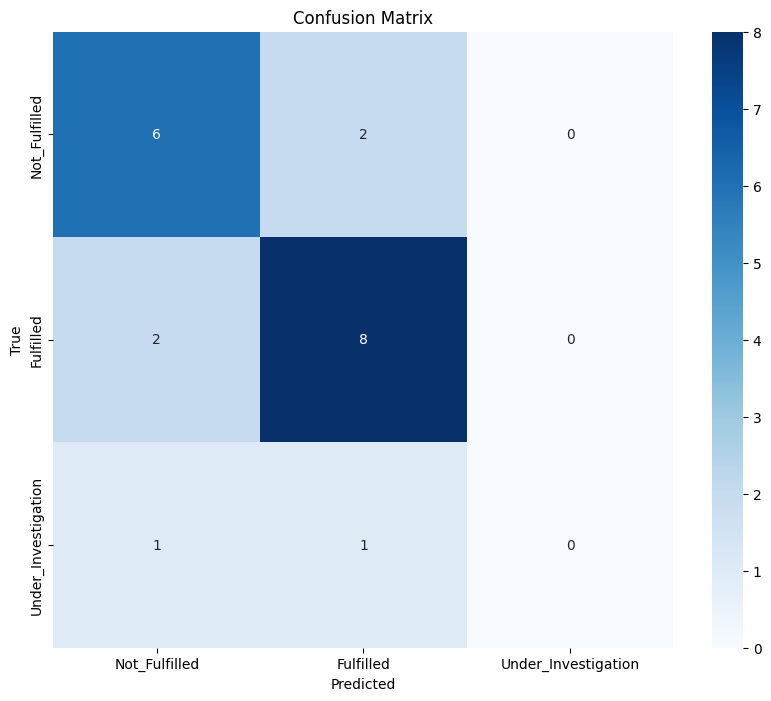


Per-class Accuracy for Final Model:
----------------------------------------
Not_Fulfilled            : 0.7500 (6/8)
Fulfilled                : 0.8000 (8/10)
Under_Investigation      : 0.0000 (0/2)

Overall Accuracy: 0.7000

ROC AUC Curve (One vs Rest) for Final Model:


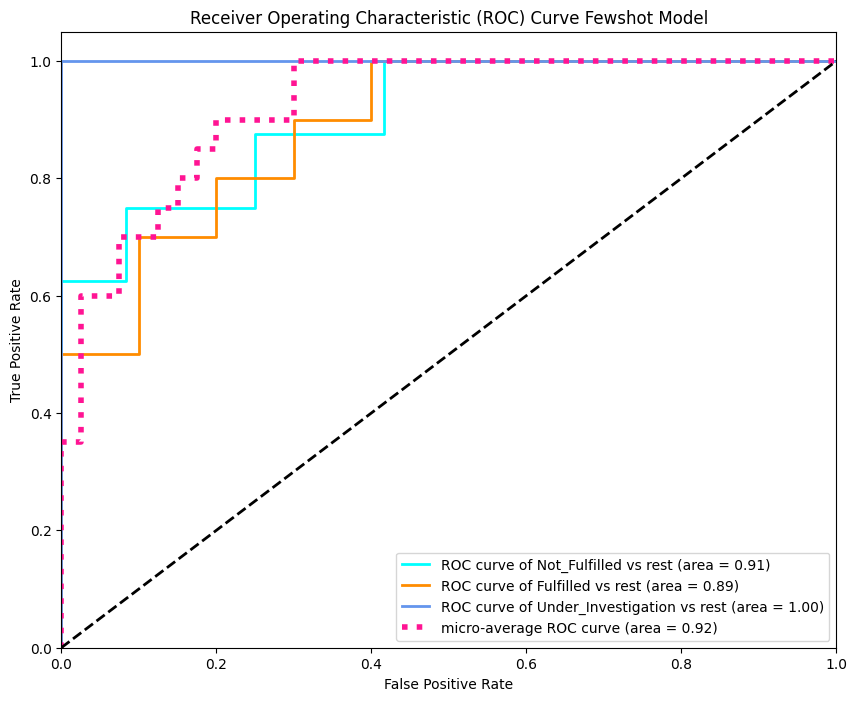


Model ROC-AUC scores:
Not_Fulfilled vs rest: 0.9062
Fulfilled vs rest: 0.8900
Under_Investigation vs rest: 1.0000
Micro-average: 0.9237


In [19]:
# --- Train Final Model and Evaluate on the Noble Test Set ---

# Train the final model on the ENTIRE CV set to use all available training data
print("\n" + "=" * 60)
print("Training final model on the entire CV set (56 samples)...")
print("=" * 60)

# Create a fresh copy of the initial fine-tuned model
final_model = copy.deepcopy(fewshot_model)

# Create a DataLoader for the full CV dataset
cv_dataset = torch.utils.data.TensorDataset(torch.tensor(X_cv, dtype=torch.float32), torch.tensor(y_cv, dtype=torch.long))
cv_loader = DataLoader(cv_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Train the model on the full CV set
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
trained_final_model = fine_tune_model(final_model, cv_loader, criterion, final_optimizer, num_epochs=50)

print("Final model training complete.")

# --- Final Evaluation Report on the NOBLE TEST SET ---
print("\n" + "=" * 60)
print("FINAL PERFORMANCE ON UNSEEN NOBLE TEST SET (20 SAMPLES)")
print("=" * 60)

# Create a DataLoader for the noble test set
test_dataset_noble = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader_noble = DataLoader(test_dataset_noble, batch_size=best_params['batch_size'], shuffle=False)

# Evaluate the final model on the noble test set
final_metrics = evaluate_model(trained_final_model, test_loader_noble, class_names)

# Classification Report
print("\nDetailed Classification Report for Final Model:")
print("-" * 60)
print(classification_report(final_metrics['targets'], final_metrics['predictions'], target_names=class_names))

# Confusion Matrix
print("\nConfusion Matrix for Final Model:")
cm = confusion_matrix(final_metrics['targets'], final_metrics['predictions'])
plot_confusion_matrix(cm, class_names, save_path=os.path.join(RESULTS_DIR, "fewshot_confusion_matrix.png"))

# Per-class Accuracy
print("\nPer-class Accuracy for Final Model:")
print("-" * 40)
for i, name in enumerate(class_names):
    true_samples_for_class = cm[i].sum()
    if true_samples_for_class > 0:
        class_accuracy = cm[i, i] / true_samples_for_class
        print(f"{name:25s}: {class_accuracy:.4f} ({cm[i, i]}/{true_samples_for_class})")
    else:
        print(f"{name:25s}: No test samples in this class")
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")


# ROC AUC Curve
print("\nROC AUC Curve (One vs Rest) for Final Model:")
plot_roc_curves(final_metrics['targets'], final_metrics['probabilities'], class_names, save_path=os.path.join(RESULTS_DIR, "final_roc_curve.png"))

How We Get a 77-Point Confusion Matrix
Think of your 77 data points as a full deck of cards. 5-fold cross-validation is a clever way to ensure that you test your model on every single card in the deck exactly once.

Here’s how it works:

Fold 1: The model trains on 61 cards and is tested on the first 16 cards. We save the predictions for these 16 cards.

Fold 2: The model trains on a different set of 61 cards and is tested on the next 16 cards (cards 17-32). We save the predictions for this new set.

Fold 3: We test on the next 16 cards (33-48) and save those predictions.

Fold 4: We test on the next 16 cards (49-64) and save those predictions.

Fold 5: We test on the final 13 cards (65-77) and save those predictions.

At the end of the 5 folds, you haven't tested on one small set of 16. Instead, you have collected the test predictions for all 77 unique data points.

The final confusion matrix is created by comparing the true labels of all 77 points to the collected test predictions for all 77 points.

Why This Is the Correct and Best Method
It's 100% Test Data: Every prediction used in the final 77-point matrix was generated when that data point was in a test set. The model had never seen that specific data point during its training phase in that fold.

More Reliable and Stable: A confusion matrix on only 16 samples is highly unstable. If the model gets just one sample wrong, the accuracy can swing wildly (e.g., from 93.7% to 87.5%). A matrix built on all 77 test results gives a much more trustworthy and stable picture of the model's true performance.

It Evaluates the Entire Dataset: This method gives you a single, comprehensive report on how your model performs across your entire evaluation set, not just one small, random slice of it.

So, to answer your direct question:
I want to show a final confusion matrix with 16 data points but aggregate of all folds on test data?

This is not possible because you can't "aggregate" five different sets of 16 predictions into a single 16-point matrix. The correct way to aggregate them is to combine them, which gives you the full set of 77 predictions.

In short: Your final 77-point confusion matrix is the correct and most robust way to report the overall test performance of your 5-fold cross-validation. The individual 16-point matrices you can generate are for diagnosing performance fold-by-fold, but the big one is your final result.